
# "Gold Recovery"
> "We examine the input feeds of a gold mining operation to try and predict our gold recovery"

- toc: true
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- hide: false

## Data description
### Technological process
- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
    - Xanthate — promoter or flotation activator;
    - Sulphate — sodium sulphide for this particular process;
    - Depressant — sodium silicate.
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate
### Parameters of stages
- air amount — volume of air
- fluid levels
- feed size — feed particle size
- feed rate

## Feature naming
Here's how we named the features:
[stage].[parameter_type].[parameter_name]
Example: rougher.input.feed_ag
- Possible values for [stage]:  
    - rougher — flotation  
    - primary_cleaner — primary purification  
    - secondary_cleaner — secondary purification  
    - final — final characteristics  
- Possible values for [parameter_type]:  
    - input — raw material parameters  
    - output — product parameters  
    - state — parameters characterizing the current state of the stage  
    - calculation — calculation characteristics  

## 1. Prepare the data

In [1]:
#collapse-hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error as MAE

### 1.1. Open the files and look into the data.

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
#collapse-output
display(train.head())
display(test.head())
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
#collapse-output
train.info()
print()
test.info()
print()
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
train.tail()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
11012,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
11013,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
11014,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
11015,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
11016,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


- The data has tons of Null values, to avoid trying to sort through all the holes we dropped them
- After trimming down the data set there is still 11017 entries
- If we struggle to find a good model we will revisit this method of approach

### 1.2. Check that recovery is calculated correctly. 
- **Using the training set, calculate recovery for the rougher.output.recovery feature.** 
- **Find the MAE between your calculations and the feature values.** 
- **Provide findings.**

In [6]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

train['rougher.calculation.recovery'] = C * (F - T) / (F * (C - T)) * 100

MAE(train['rougher.output.recovery'], train['rougher.calculation.recovery'])

9.555596961987514e-15

- This is an incredibly small number, we're safe to proceed with testing
- Tried following suit with labeling standards

### 1.3. Analyze the features not available in the test set. 
- **What are these parameters?** 
- **What is their type?**

In [7]:
columns_full = set(full.columns)
columns_test = set(test.columns)

removable_features = list(columns_full.difference(columns_test))

In [8]:
removable_features.remove('final.output.recovery')
removable_features.remove('rougher.output.recovery')

removable_features

['primary_cleaner.output.tail_ag',
 'final.output.concentrate_ag',
 'secondary_cleaner.output.tail_ag',
 'final.output.tail_au',
 'secondary_cleaner.output.tail_sol',
 'final.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'primary_cleaner.output.concentrate_sol',
 'final.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.tail_sol',
 'rougher.output.concentrate_au',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.tail_au',
 'primary_cleaner.output.tail_sol',
 'final.output.tail_ag',
 'rougher.calculation.au_pb_ratio',
 'primary_cleaner.output.concentrate_ag',
 'secondary_cleaner.output.tail_pb',
 'final.output.concentrate_pb',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.concentrate_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'final.output.concentrate_au',
 'rougher.output.concentrate_sol',
 'final.output.tail_pb',
 'rougher.output.concentra

- All the missing columns from the test set appear to be output values or calculations
- We have no Target columns in the test dataset making it useless for testing.

### 1.4. Perform data preprocessing.

In [9]:
STATE = 12345

In [10]:
full.dropna(inplace=True)
full.reset_index(drop=True, inplace=True)

full.shape

(16094, 87)

In [11]:
train, test = train_test_split(full, test_size=0.25, random_state=STATE)

- With missing Target columns in the test set I decided to trash the train and test data and resplit the full data set
- If this method wasn't acceptable to the owner or project supervisor I would manually calculate the target values as I did earlier in this project.
- Roughly 6000 data entries were trashed due to Null values, if this causes issues down the line we will revisit scrapping these points

## 2. Analyze the data

### 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [12]:
ORES = ['au', 'ag', 'pb']
STAGES = ['rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']

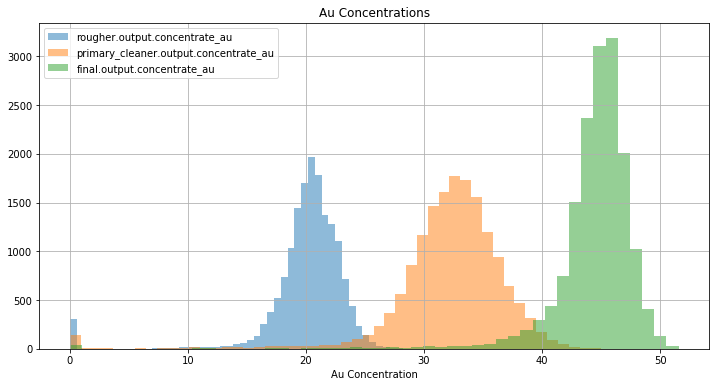

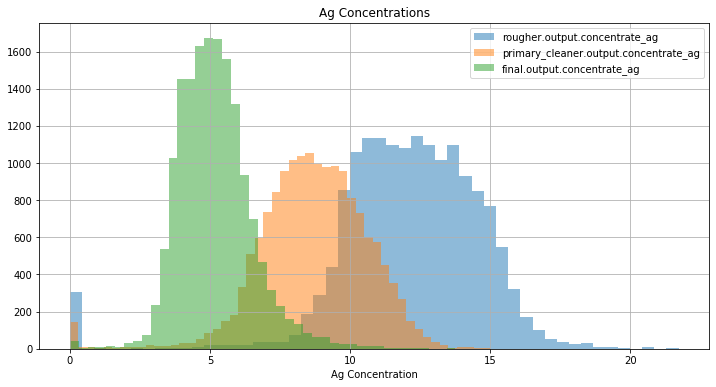

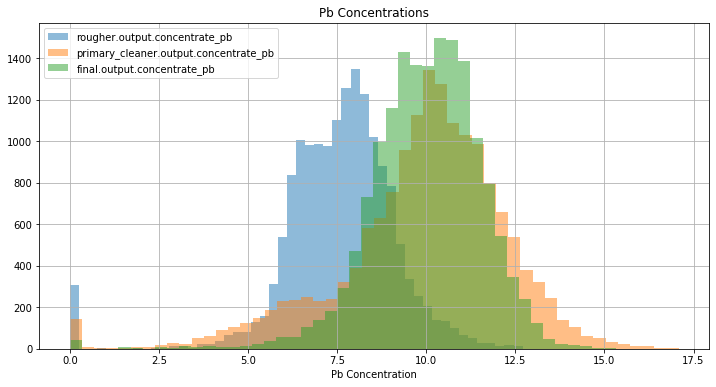

In [13]:
for ore in ORES:
    plt.figure(figsize=(12,6))
    for stage in STAGES:
        plt.hist(full[stage + ore], label=(stage + ore), bins = 50, alpha=0.5)
    plt.xlabel(ore.capitalize() + ' Concentration')
    plt.title(ore.capitalize() + ' Concentrations')
    plt.legend()
    plt.grid()
    
    plt.show()

- Gold(Au) concentrations increase with each stage
- Silver(Ag) gets filtered out and goes down with each stage
- Lead(Pb) stays roughly the same throughout the process
- There appears to be some outliers where ore == 0

### 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

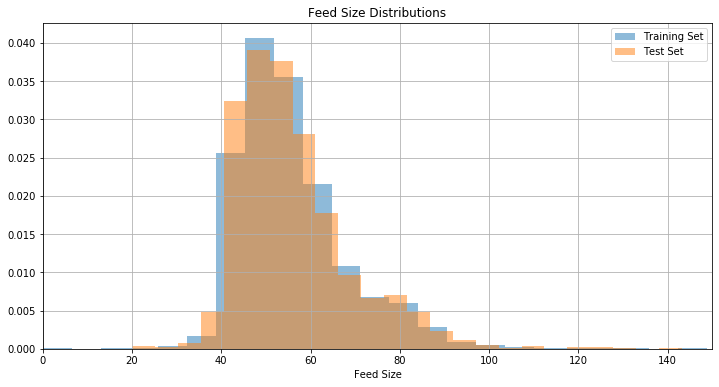

In [14]:
plt.figure(figsize=(12,6))
plt.hist(train['rougher.input.feed_size'], label='Training Set', bins=75, alpha=0.5, density=True)
plt.hist(test['rougher.input.feed_size'], label='Test Set', bins=75, alpha=0.5, density=True)
plt.xlabel('Feed Size')
plt.xlim((0, 150))
plt.title('Feed Size Distributions')
plt.legend()
plt.grid()

plt.show()

- The feed size distributions appear to be very similar making things safe to proceed
- There are some major outliers in the dataset extending into the 300+ range, an xlim was placed to get a better view of the bulk of the data

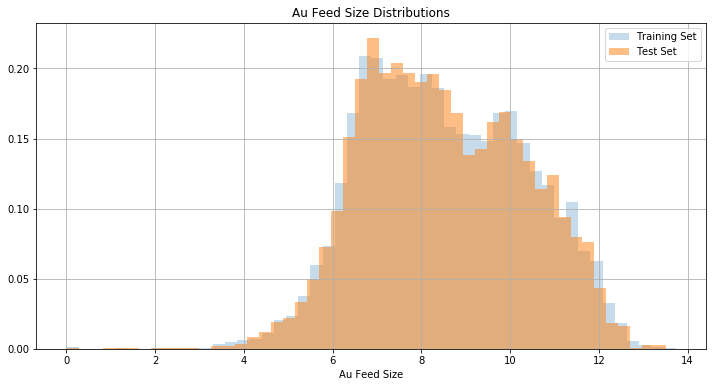

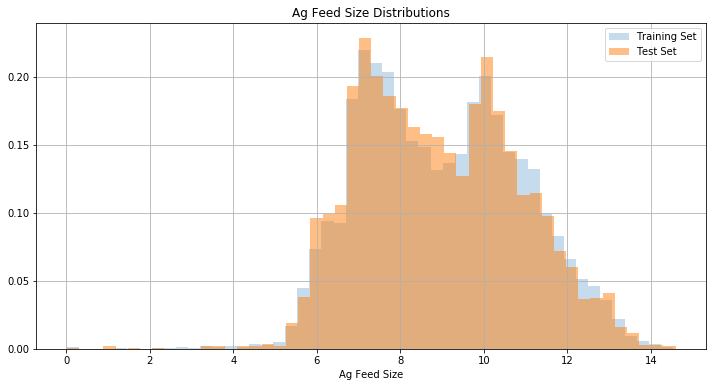

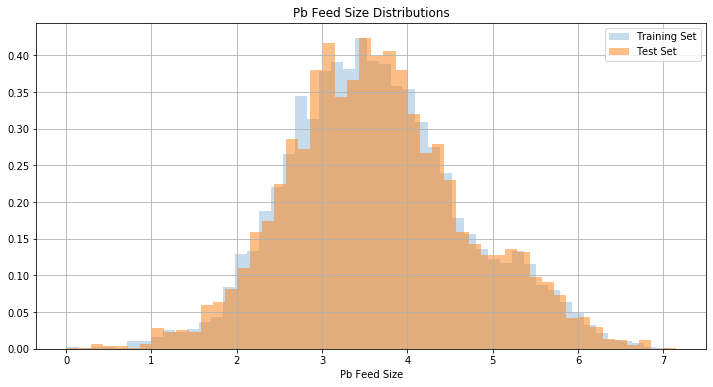

In [15]:
for ore in ORES:
    plt.figure(figsize=(12,6))
    plt.hist(train['rougher.input.feed_' + ore], label='Training Set', bins = 50, alpha=0.25, density=True)
    plt.hist(test['rougher.input.feed_' + ore], label= 'Test Set', bins = 50, alpha=0.50, density=True)
    plt.xlabel(ore.capitalize() + ' Feed Size')
    plt.title(ore.capitalize() + ' Feed Size Distributions')
    plt.legend()
    plt.grid()
    
    plt.show()

- Individual distributions for Gold(Au), Silver(Ag), and Lead(Pb) appear to be similar as well 

### 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 
- **Do you notice any abnormal values in the total distribution?** 
- **If you do, is it worth removing such values from both samples?** 
- **Describe the findings and eliminate anomalies.**

In [16]:
print('Train Size Before:', train.shape[0])
print('Test Size Before:', test.shape[0])
train = train[train['rougher.input.feed_size'] <= 120]
test = test[test['rougher.input.feed_size'] <= 120]
for ore in ORES:
    for stage in STAGES:
        [stage + ore]
        train = train[train[stage + ore] > 0]
        test = test[test[stage + ore] > 0] 
print('Train Size After:', train.shape[0])
print('Test Size After:', test.shape[0])


Train Size Before: 12070
Test Size Before: 4024
Train Size After: 11707
Test Size After: 3884


## 3. Build the model

In [17]:
train = train.drop(removable_features + ['date'], axis=1)
test = test.drop(removable_features + ['date'], axis=1)

print(train.shape)
test.shape

(11707, 54)


(3884, 54)

- Removed columns that were not initially available in the test set (excluding target columns)

In [18]:
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
targets_train = train[['rougher.output.recovery', 'final.output.recovery']]

features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
targets_test = test[['rougher.output.recovery', 'final.output.recovery']]

- Datasets prepared for model training

## 3.1. Write a function to calculate the final sMAPE value.

In [19]:
def smape(target, predictions):
    return np.sum(np.abs(target - predictions) / ((np.abs(target) + np.abs(predictions)) / 2)) / len(target) * 100
def final_smape(targets, predictions):
    return (.25 * smape(targets[0], predictions[0])) + (.75 * smape(targets[1], predictions[1]))

- Broke the smape function into 2 parts, so that smape can still be called on a single target 

## 3.2. Train different models. 
- **Evaluate them using cross-validation.** 
- **Pick the best model and test it using the test sample. Provide findings.**

### MultiOutputRegressor - Ridge

In [20]:
model = MultiOutputRegressor(Ridge(random_state=STATE))
scores = cross_validate(
    model, 
    features_train, 
    targets_train.values, 
    cv=10,
    scoring=make_scorer(final_smape, greater_is_better=False),
    n_jobs=-1
)

In [21]:
scores['test_score'] = np.abs(scores['test_score'])
print('All Scores:', scores['test_score'])
print('Min Score:', scores['test_score'].min())
print('Max Score:', scores['test_score'].max())
print('Mean Score', scores['test_score'].mean())

All Scores: [3.28774945 5.78103106 3.30564647 1.78031086 8.5693093  4.72647352
 3.0575838  2.57316625 2.14893175 4.33952347]
Min Score: 1.7803108614465526
Max Score: 8.56930929520799
Mean Score 3.9569725918259193


- We have a set of decent scores, time to train model 2 and compare

### MultiOutput - RandomForestRegressor

In [22]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=20, random_state=STATE))

In [23]:
scores = cross_validate(
    model, 
    features_train, 
    targets_train.values, 
    cv=10,
    scoring=make_scorer(final_smape, greater_is_better=False),
    n_jobs=-1
)

In [24]:
scores['test_score'] = np.abs(scores['test_score'])
print('All Scores:', scores['test_score'])
print('Min Score:', scores['test_score'].min())
print('Max Score:', scores['test_score'].max())
print('Mean Score', scores['test_score'].mean())

All Scores: [3.4162687  6.70766298 1.83670086 2.70828718 6.03572728 4.60284131
 2.83019246 0.74377943 1.02469512 0.81966925]
Min Score: 0.743779429586609
Max Score: 6.707662976360825
Mean Score 3.0725824553865158


- This is computationally expensive and so cross_validation was done less times
- Overall though these scores appear to be much better than our previous model

### Sanity Test

In [25]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, targets_train.values)
dummy_pred = dummy_model.predict(features_test)

In [26]:
print(f"Baseline using the mean: {final_smape(targets_test.values, dummy_pred):.2f}% sMAPE")

Baseline using the mean: 7.31% sMAPE


In [27]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=20, random_state=STATE))
model.fit(features_train, targets_train.values)
predictions = model.predict(features_test)

In [28]:
print(f"Our model yields: {final_smape(targets_test.values, predictions):.2f}% sMAPE")

Our model yields: 3.77% sMAPE


## Final Conclusion:

- We were able to achieve a 3.54% improvement over the sanity test model.
- With more time we may be able to bring this number down even more by pruning out less data points
- The model chosen may not appeal to the company due to its overall computational cost
- Looking into more advanced models and estimators may also be of benefit to the company